# **Loading Dataset**

In [ ]:
from datasets import load_dataset
import pandas as pd


# Load VQA-RAD from Hugging Face Hub
ds = load_dataset("flaviagiammarino/vqa-rad")

# Convert to Pandas for easier analysis
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Display dataset structure
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {train_df.columns.tolist()}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

Train samples: 1793
Test samples: 451
Features: ['image', 'question', 'answer']


In [ ]:
# Verify actual column names to prevent future KeyErrors
print(f"\nActual Dataset Columns: {train_df.columns.tolist()}")


Actual Dataset Columns: ['image', 'question', 'answer']


# **EDA**

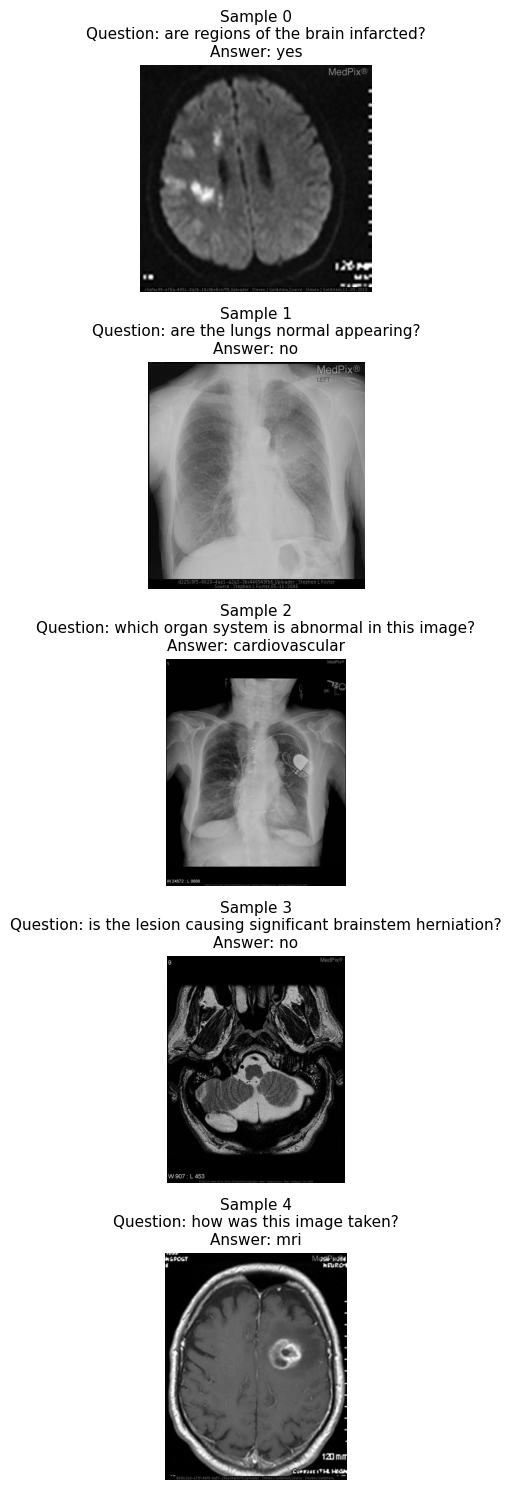

In [ ]:
import matplotlib.pyplot as plt
# 1. Print the training dataset (5 rows)import matplotlib.pyplot as plt

def show_first_n_samples(df, n=5):
    plt.figure(figsize=(15, 3 * n))

    for i in range(n):
        img = full_df.loc[i, "image"]
        question = full_df.loc[i, "question"]
        answer = full_df.loc[i, "answer"]

        plt.subplot(n, 1, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Sample {i}\n"
            f"Question: {question}\n"
            f"Answer: {answer}",
            fontsize=11
        )

    plt.tight_layout()
    plt.show()

# Display first 5 training samples
show_first_n_samples(train_df, n=5)


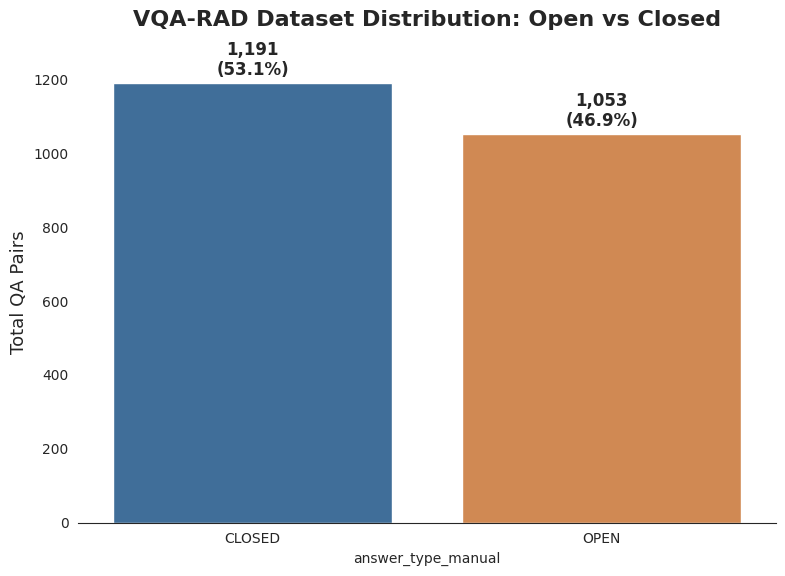

In [ ]:
# 2. Question category Distribution
import seaborn as sns
# Function to categorize answers
def categorize_answer(ans):
    ans = str(ans).lower().strip()
    return 'CLOSED' if ans in ['yes', 'no'] else 'OPEN'

# Apply to full and train data
full_df['answer_type_manual'] = full_df['answer'].apply(categorize_answer)
type_counts = full_df['answer_type_manual'].value_counts()

# Create the Chart
plt.figure(figsize=(9, 6))
colors = ['#316EA8', '#E5863E']
sns.set_style("white")

ax = sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index, palette=colors, legend=False)

plt.title('VQA-RAD Dataset Distribution: Open vs Closed', fontsize=16, fontweight='bold', pad=25)
plt.ylabel('Total QA Pairs', fontsize=13)

# Add Percentages on top
total = len(full_df)
for i, v in enumerate(type_counts.values):
    percentage = v / total * 100
    ax.text(i, v + 20, f"{v:,}\n({percentage:.1f}%)", ha='center', fontweight='bold', fontsize=12)

sns.despine(left=True)
plt.show()

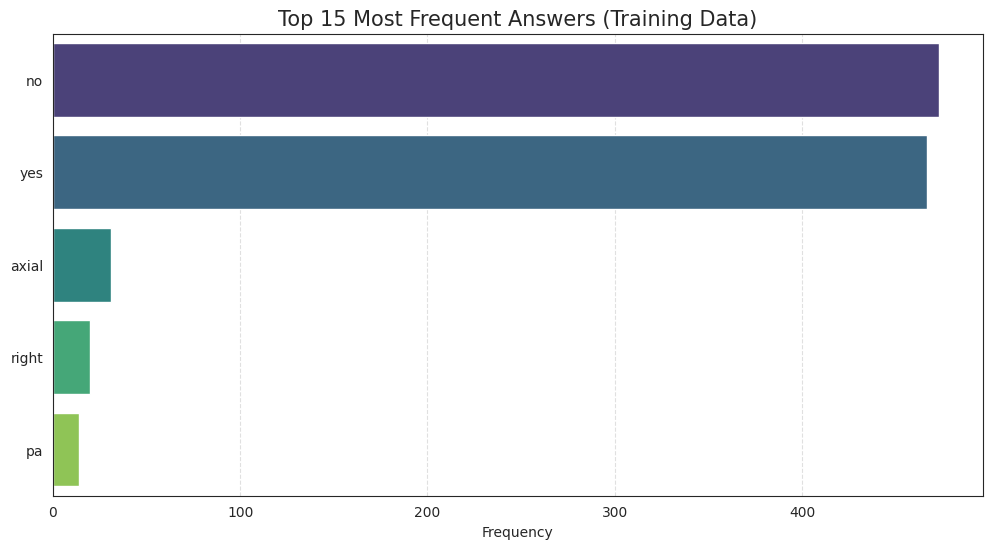

Total Unique Answers in Train: 432


In [ ]:
# 3. Yes/No bias check in training data
from collections import Counter

answers = train_df["answer"].str.lower().str.strip().tolist()
answer_counts = Counter(answers)
top_answers = answer_counts.most_common(5)
labels, counts = zip(*top_answers)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(labels), hue=list(labels), palette="viridis", legend=False)
plt.title("Top 15 Most Frequent Answers (Training Data)", fontsize=15)
plt.xlabel("Frequency")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print(f"Total Unique Answers in Train: {len(answer_counts)}")

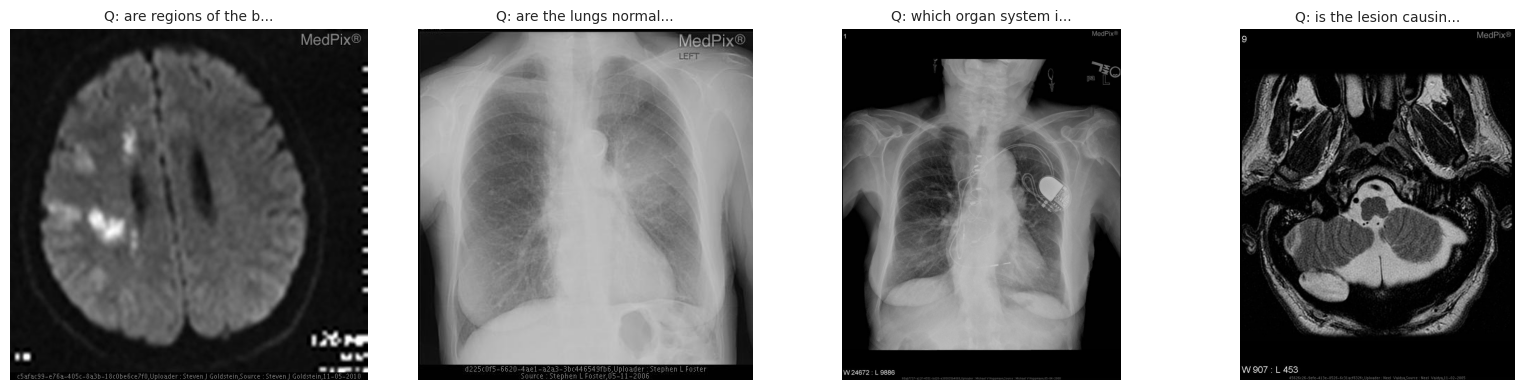

In [ ]:
# 4. Modality check: Visualize sample images
def show_medical_images(dataframe, n=4):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        sample = dataframe.iloc[i]
        plt.imshow(sample['image'])
        plt.title(f"Q: {sample['question'][:20]}...", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_medical_images(train_df)

In [ ]:
import hashlib

# 5. Image to question ratio for data leakage test
# Helper function to create a unique ID from the image content
def get_image_hash(img_obj):
    return hashlib.md5(img_obj.tobytes()).hexdigest()

train_df['image_id'] = train_df['image'].apply(get_image_hash)
test_df['image_id'] = test_df['image'].apply(get_image_hash)

unique_train_images = train_df['image_id'].nunique()
print(f"Unique Images in Train: {unique_train_images}")
print(f"Average Questions per Image: {len(train_df)/unique_train_images:.2f}")

# Check for Overlap (Leakage)
train_ids = set(train_df['image_id'].unique())
test_ids = set(test_df['image_id'].unique())
overlap = train_ids.intersection(test_ids)

if len(overlap) > 0:
    print(f" WARNING: {len(overlap)} unique images appear in both Train and Test sets")
else:
    print("Good, No image overlap detected. Data split is clean.")

Unique Images in Train: 313
Average Questions per Image: 5.73


In [ ]:
# 6. Create Unique IDs for Images AND Triplets
def get_hash(obj): return hashlib.md5(str(obj).encode()).hexdigest()

train_df['img_hash'] = train_df['image'].apply(lambda x: hashlib.md5(x.tobytes()).hexdigest())
test_df['img_hash'] = test_df['image'].apply(lambda x: hashlib.md5(x.tobytes()).hexdigest())

# Triplet = Image + Clean Question + Clean Answer
train_df['triplet_id'] = train_df['img_hash'] + train_df['question'].str.lower() + train_df['answer'].str.lower()
test_df['triplet_id'] = test_df['img_hash'] + test_df['question'].str.lower() + test_df['answer'].str.lower()

overlap_images = set(train_df['img_hash']).intersection(set(test_df['img_hash']))
leakage_triplets = set(train_df['triplet_id']).intersection(set(test_df['triplet_id']))

print(f"Images Shared (Standard for VQA-RAD): {len(overlap_images)}")
print(f"Triplets to Drop (The 'Real' Leakage): {len(leakage_triplets)}")

Images Shared (Standard for VQA-RAD): 202
Triplets to Drop (The 'Real' Leakage): 0


The result confirms that VQA-RAD uses a question-level split, not an image-level split. This means the model is tested on its ability to answer new, unseen clinical questions about medical images it may have already processed during training.

In [ ]:
# CAN REMOVE THIS LATER CANNOT CATEGORIZE IMAGES INTO MODALITY
def heuristic_modality(question):
    q = str(question).lower()
    if any(word in q for word in ['ct', 'computed tomography', 'axial', 'window']):
        return 'CT'
    elif any(word in q for word in ['mri', 't1', 't2', 'flair', 'brainstem']):
        return 'MRI'
    elif any(word in q for word in ['x-ray', 'cxr', 'radiograph', 'lungs', 'chest']):
        return 'X-Ray'
    else:
        return 'Unknown/Other'

# Apply to your dataframes
train_df['modality_heuristic'] = train_df['question'].apply(heuristic_modality)
test_df['modality_heuristic'] = test_df['question'].apply(heuristic_modality)

# Check the distribution
print(train_df['modality_heuristic'].value_counts())

modality_heuristic
Unknown/Other    1480
CT                230
X-Ray              45
MRI                38
Name: count, dtype: int64


# **PRE PROCESSING FOR CNN + LSTM**

**a. Image Preprocessing (Vision Branch)**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# ResNet-50 standard normalization and resizing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(img_obj):
    # Ensure image is RGB (some medical scans are grayscale)
    if img_obj.mode != 'RGB':
        img_obj = img_obj.convert('RGB')
    return image_transform(img_obj)

**b. Text Preprocessing (LSTM Branch)**

In [ ]:
from collections import Counter

# Build Vocabulary from training questions only to prevent leakage
all_tokens = " ".join(train_df['question'].str.lower()).split()
vocab_counts = Counter(all_tokens)
# Map words to IDs (0=Padding, 1=Unknown)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def preprocess_text(text, max_len=20):
    tokens = str(text).lower().split()
    # Map tokens to IDs, use <UNK> if word not in training vocab
    sequence = [vocab.get(token, 1) for token in tokens]
    # Pad or truncate to fixed length of 20
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    return torch.tensor(sequence, dtype=torch.long)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize and fit the encoder on all unique answers
label_encoder = LabelEncoder()
all_answers = pd.concat([train_df['answer'], test_df['answer']]).str.lower().str.strip()
label_encoder.fit(all_answers)

# Add encoded labels to dataframes
train_df['label'] = label_encoder.transform(train_df['answer'].str.lower().str.strip())
test_df['label'] = label_encoder.transform(test_df['answer'].str.lower().str.strip())

num_classes = len(label_encoder.classes_)
print(f"Fixed Classification Dictionary Size: {num_classes} classes")

Fixed Classification Dictionary Size: 517 classes


In [ ]:
from torch.utils.data import Dataset, DataLoader

class VQARADDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_tensor = preprocess_image(row['image'])
        question_tensor = preprocess_text(row['question'])
        label = torch.tensor(row['label'], dtype=torch.long)

        return image_tensor, question_tensor, label

# Create DataLoaders
train_loader = DataLoader(VQARADDataset(train_df), batch_size=32, shuffle=True)
test_loader = DataLoader(VQARADDataset(test_df), batch_size=32, shuffle=False)

# Verification
img_batch, ques_batch, label_batch = next(iter(train_loader))
print(f"Batch Shapes -> Image: {img_batch.shape}, Question: {ques_batch.shape}, Labels: {label_batch.shape}")

Batch Shapes -> Image: torch.Size([32, 3, 224, 224]), Question: torch.Size([32, 20]), Labels: torch.Size([32])


# **CNN + LSTM Model**

**a. Model Architecture**

In [ ]:
import torch.nn as nn
import torchvision.models as models

class BaseModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(BaseModel, self).__init__()

        # 1. Vision Branch: Pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)
        # Freeze parameters as per diagram "ImageNet, Frozen"
        for param in resnet.parameters():
            param.requires_grad = False
        # Remove the final classification layer to get 2048D features
        self.vision_branch = nn.Sequential(*list(resnet.children())[:-1])

        # 2. Text Branch: Embedding + LSTM
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)

        # 3. Multimodal Fusion (Linear Projection)
        # 2048 (Vision) + 256 (LSTM Hidden State) = 2304
        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 4. Classifier (Softmax Output)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, images, questions):
        # Vision Branch processing
        vision_features = self.vision_branch(images) # Shape: [batch, 2048, 1, 1]
        vision_features = torch.flatten(vision_features, 1) # Shape: [batch, 2048]

        # Text Branch processing
        embedded = self.embedding(questions)
        _, (hidden, _) = self.lstm(embedded)
        text_features = hidden[-1] # Take the final hidden state (h_t)

        # Concatenation [2048 ⊕ H]
        combined = torch.cat((vision_features, text_features), dim=1)

        # Fusion and Prediction
        fused = self.fusion_layer(combined)
        logits = self.classifier(fused)
        return logits

**b. Model Initialization**

In [ ]:
# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseModel(vocab_size=len(vocab), num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 252MB/s]


In [ ]:
import torch
import torch.optim as optim


# 1. Basic Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseModel(vocab_size=len(vocab), num_classes=num_classes).to(device)


# 2. Refined Hyperparameters


learning_rate = 1e-4
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


# 3. Intelligent Scheduler


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


print(f"Model ready on {device}. Starting with Learning Rate: {learning_rate}")


Model ready on cpu. Starting with Learning Rate: 0.0001


In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, ques, labels in loader:
            imgs, ques, labels = imgs.to(device), ques.to(device), labels.to(device)
            outputs = model(imgs, ques)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)


# --- START RESTART TRAINING ---
num_epochs = 20
best_test_acc = 0.0


for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for imgs, ques, labels in train_loader:
        imgs, ques, labels = imgs.to(device), ques.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, ques)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient Clipping (Prevents the 35% stall by stabilizing updates)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # --- EVALUATION PHASE ---
    train_acc = 100 * correct_train / total_train
    test_acc = evaluate_model(model, test_loader, device)
    avg_loss = running_loss / len(train_loader)

    # Update Scheduler based on Test Accuracy
    scheduler.step(test_acc)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")
    print(f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | LR: {current_lr:.2e}")

    # Save Best Model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_vqa_model.pth')
        print("--> New Best Accuracy! Model Saved.")
    print("-" * 40)


print(f"\nFinal Best Test Accuracy: {best_test_acc:.2f}%")

Epoch [1/20] | Loss: 4.3811
Train Acc: 28.44% | Test Acc: 28.38% | LR: 1.00e-04
--> New Best Accuracy! Model Saved.
----------------------------------------
Epoch [2/20] | Loss: 3.8802
Train Acc: 31.57% | Test Acc: 27.49% | LR: 1.00e-04
----------------------------------------
Epoch [3/20] | Loss: 3.7756
Train Acc: 31.40% | Test Acc: 29.71% | LR: 1.00e-04
--> New Best Accuracy! Model Saved.
----------------------------------------
Epoch [4/20] | Loss: 3.8359
Train Acc: 32.68% | Test Acc: 28.82% | LR: 1.00e-04
----------------------------------------
Epoch [5/20] | Loss: 3.6770
Train Acc: 32.74% | Test Acc: 33.26% | LR: 1.00e-04
--> New Best Accuracy! Model Saved.
----------------------------------------
Epoch [6/20] | Loss: 3.7001
Train Acc: 32.74% | Test Acc: 32.59% | LR: 1.00e-04
----------------------------------------
Epoch [7/20] | Loss: 3.3053
Train Acc: 33.02% | Test Acc: 31.26% | LR: 1.00e-04
----------------------------------------
Epoch [8/20] | Loss: 3.0613
Train Acc: 34.63%

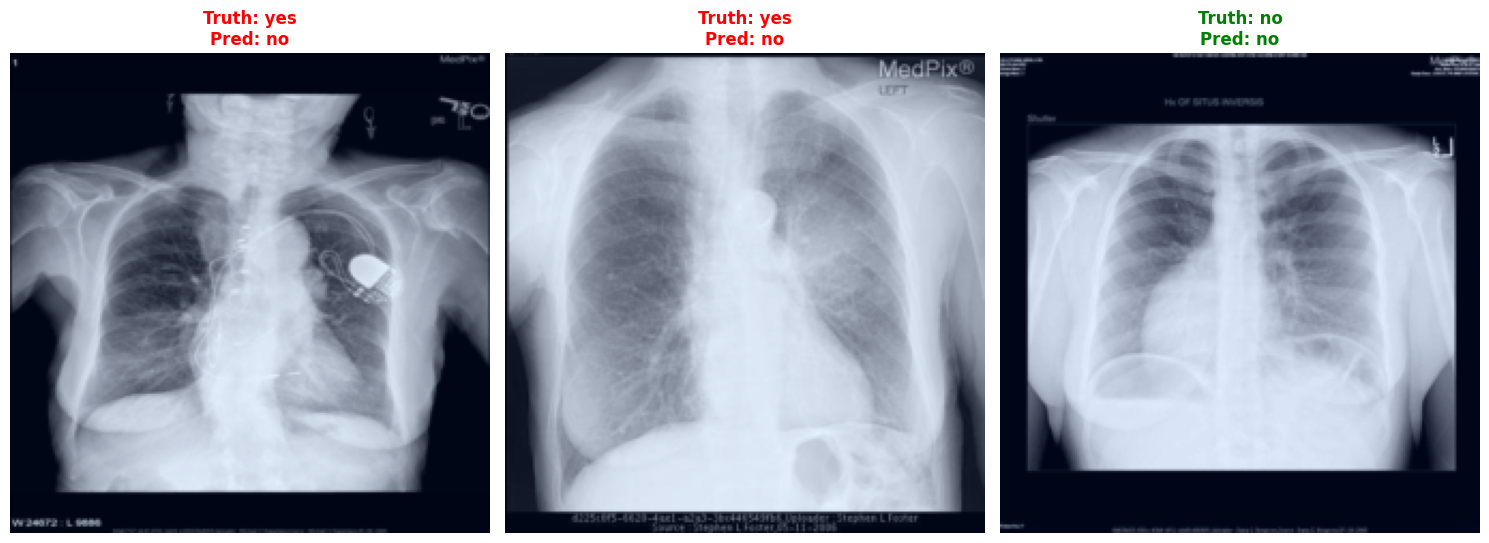

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Updated function signature to accept 'label_encoder'
def visualize_results(model, loader, device, label_encoder, num_samples=3):
    model.eval()
    samples_found = 0

    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for imgs, ques, labels in loader:
            imgs, ques, labels = imgs.to(device), ques.to(device), labels.to(device)

            outputs = model(imgs, ques)
            _, predicted = torch.max(outputs, 1)

            for i in range(imgs.size(0)):
                if samples_found >= num_samples:
                    break

                samples_found += 1

                # 1. Process Image
                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                # Normalize to [0,1] to prevent dark/static images
                img = (img - img.min()) / (img.max() - img.min())

                # 2. Decode Answers using LabelEncoder
                # .classes_[index] gives the text label directly
                pred_idx = predicted[i].item()
                true_idx = labels[i].item()

                try:
                    pred_text = label_encoder.classes_[pred_idx]
                except IndexError:
                    pred_text = "Error"

                try:
                    true_text = label_encoder.classes_[true_idx]
                except IndexError:
                    true_text = "Error"

                # 3. Plot
                plt.subplot(1, num_samples, samples_found)
                plt.imshow(img)

                color = 'green' if pred_idx == true_idx else 'red'

                plt.title(f"Truth: {true_text}\nPred: {pred_text}",
                          color=color, fontsize=12, fontweight='bold')
                plt.axis('off')

            if samples_found >= num_samples:
                break

    plt.tight_layout()
    plt.show()

# --- HOW TO RUN ---
# Just pass the 'label_encoder' variable you created earlier
model.load_state_dict(torch.load('best_vqa_model.pth'))

# Pass 'label_encoder' as the 4th argument
visualize_results(model, test_loader, device, label_encoder, num_samples=3)

/tmp/ipython-input-3295563995.py:97: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


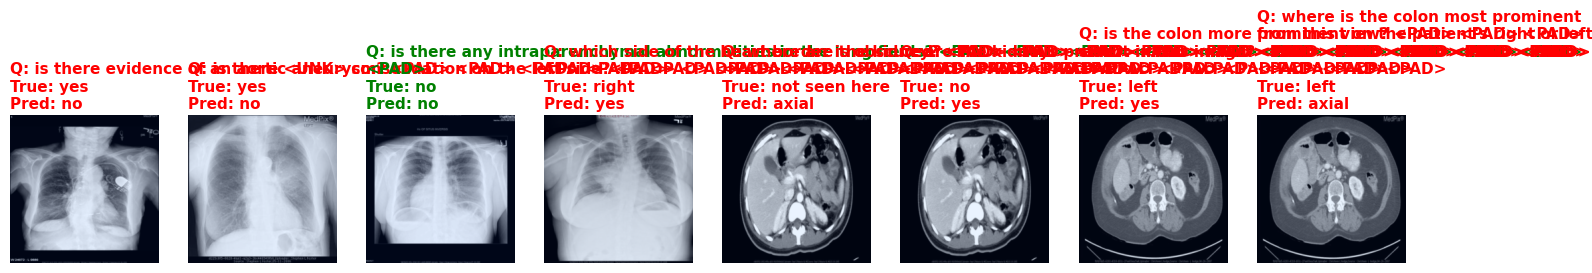

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- FINAL POLISHED VISUALIZATION FUNCTION ---
def visualize_results_with_question(model, loader, device, label_encoder, vocab, num_samples=8):
    model.eval()
    samples_found = 0

    # 1. SMART VOCAB DETECTION
    idx_to_word = {}
    vocab_type = "unknown"

    if hasattr(vocab, 'decode'):
        vocab_type = "tokenizer"
    elif isinstance(vocab, list):
        vocab_type = "list"
    elif isinstance(vocab, dict):
        # Check if it maps Word->Int (keys are strings)
        first_key = list(vocab.keys())[0]
        if isinstance(first_key, str):
            # Invert it to Int->Word
            idx_to_word = {v: k for k, v in vocab.items()}
            vocab_type = "dict_inverted"
        else:
            idx_to_word = vocab
            vocab_type = "dict"

    # Define tokens to hide
    # Add any other special tokens your tokenizer uses here
    tokens_to_hide = {'<pad>', '<unk>', '<start>', '<end>', '[PAD]', '[UNK]'}

    plt.figure(figsize=(18, 6))

    with torch.no_grad():
        for imgs, ques, labels in loader:
            imgs, ques, labels = imgs.to(device), ques.to(device), labels.to(device)

            outputs = model(imgs, ques)
            _, predicted = torch.max(outputs, 1)

            for i in range(imgs.size(0)):
                if samples_found >= num_samples:
                    break

                samples_found += 1

                # --- A. Process Image ---
                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())

                # --- B. Process Labels ---
                pred_idx = predicted[i].item()
                true_idx = labels[i].item()
                try:
                    pred_text = label_encoder.classes_[pred_idx]
                    true_text = label_encoder.classes_[true_idx]
                except:
                    pred_text = str(pred_idx)
                    true_text = str(true_idx)

                # --- C. PROCESS QUESTION (CLEAN) ---
                q_indices = ques[i].cpu().numpy()
                q_words = []

                if vocab_type == "tokenizer":
                    q_text = vocab.decode(q_indices, skip_special_tokens=True)
                else:
                    for idx in q_indices:
                        word = ""
                        if vocab_type == "list":
                            if idx < len(vocab): word = vocab[idx]
                        elif vocab_type in ["dict", "dict_inverted"]:
                            word = idx_to_word.get(idx, "")

                        # CLEAN FILTER: Only add real words
                        word_str = str(word)
                        if word_str and word_str not in tokens_to_hide:
                            q_words.append(word_str)

                    q_text = " ".join(q_words)

                # --- D. Plot ---
                plt.subplot(1, num_samples, samples_found)
                plt.imshow(img)

                color = 'green' if pred_idx == true_idx else 'red'

                # Use wrap=True to handle long questions nicely
                plt.title(f"Q: {q_text}\nTrue: {true_text}\nPred: {pred_text}",
                          color=color, fontsize=11, fontweight='bold', loc='left', wrap=True)
                plt.axis('off')

            if samples_found >= num_samples:
                break

    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
# Pass your vocab dict/list here
visualize_results_with_question(
    model=model,
    loader=test_loader,
    device=device,
    label_encoder=label_encoder,
    vocab=vocab,  # <--- Your vocab variable goes here
    num_samples=8
)